# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.keras.backend.set_floatx('float64')

# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import math
import time
import timeit
from   tqdm    import tqdm
import pandas  as pd
import numpy   as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot                        as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics import RegressionEvaluation


print('[INFO] Libraries imported')

[INFO] Libraries imported


# Parameters

In [3]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## CUDA

In [4]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Training paramers

In [5]:
Lag        =   12
Horizon    =   4
#
epochs     =  200
batch_size =   32

Transformation = True

# Importing data

In [6]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.35 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
# df = pd.DataFrame( df[['Temperature', 'Humidity', 'NO2', 'CO']] )
df = pd.DataFrame( df[['NO2', 'CO']] )
# df = pd.DataFrame( df[ 'CO' ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,186.210526,248.947368
2022-02-19 00:05:00,151.052632,232.473684
2022-02-19 00:10:00,135.315789,226.947368


In [9]:
targetSeries = df.columns[-1]

## Include MA-based features

In [10]:
# df['MA6']  = df[ targetSeries ].rolling(6).mean()
# df['MA12'] = df[ targetSeries ].rolling(12).mean()

# df['Hour'] = df.index.hour

## Split Training/Testing set

In [11]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

In [12]:
print('Training: ', df_train.shape[0])
print('Testing:  ', df_test.shape[0])

Training:  17116
Testing:   4280


## Visualize Training & Testing data

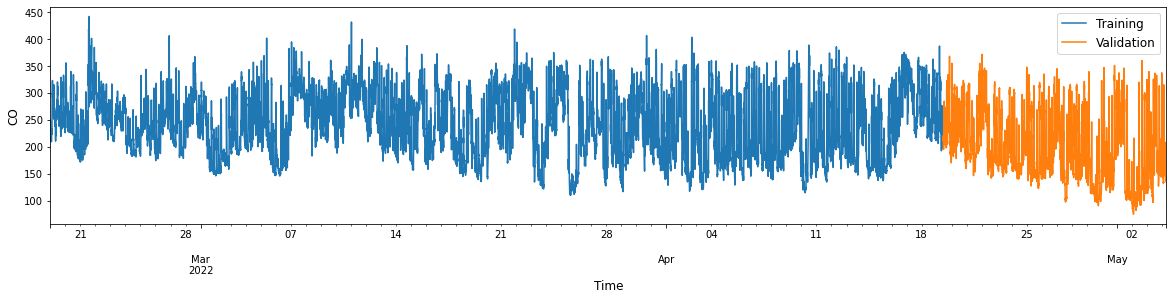

In [13]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Validation', 'Testing'], fontsize = 12);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

## Fix lag

In [14]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Contruction of fitting data for training a forecasting model

### Data Transformation

In [15]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(-df.min().min(), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Data scaling 

In [16]:
for feature in df_train.columns:
    if (feature == targetSeries): continue

    # Setup scaler
    #
    scaler = StandardScaler()

    # Performing Scaling - for each feature
    df_train[feature] = scaler.fit_transform( df_train[feature].to_numpy().reshape(-1,1) )
    df_test[feature]  = scaler.transform( df_test[feature].to_numpy().reshape(-1,1) )


# Setup scaler
#
scaler = StandardScaler()

df_train[targetSeries] = scaler.fit_transform( df_train[targetSeries].to_numpy().reshape(-1,1) )
df_test[targetSeries]  = scaler.transform( df_test[targetSeries].to_numpy().reshape(-1,1) )

### Include date/time features

In [17]:
# df_train['Time (sin)'] = np.sin( df_train.index.hour + df_train.index.minute / 60 )
# df_train['Time (cos)'] = np.cos( df_train.index.hour + df_train.index.minute / 60 )
# #
# df_test['Time (sin)']  = np.sin( df_test.index.hour + df_test.index.minute / 60 )
# df_test['Time (cos)']  = np.cos( df_test.index.hour + df_test.index.minute / 60 )

### Create fitting data 

In [18]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1, includeDate = False):
    
    if (targetSeries is None):
        print('[INFO] Target series is not defined')
        return (None, None, None)
    
    dataX, CurrentValue, dataY = [], [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy().tolist() 
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            Instance = np.concatenate([Instance, myDate], axis = -1)

        # Current value
        CurrentValue.append( df[ targetSeries ].to_numpy()[i+Lag-1] )
        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY), np.array(CurrentValue) )

In [19]:
trainX, trainY, _                = create_dataset(df           = df_train, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,
                                                  overlap      = Horizon,)

testX,  testY, test_CurrentValue = create_dataset(df           = df_test, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,                                                
                                                  overlap      = 1)


# trainX = np.expand_dims(trainX, axis=-1)
# testX  = np.expand_dims(testX, axis=-1)
print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4277/4277 [00:01<00:00, 2339.99it/s]


Training instances:     4276
Testing instances:      4277


In [20]:
trainX.shape, trainY.shape

((4276, 11, 2), (4276, 4))

# Forecasting model

In [21]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

2022-05-11 13:48:37.415865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.models                  import *
# Inputs
#
Inputs = Input(shape = (trainX.shape[1], trainX.shape[2]))


# Encoder
#
Encoder = LSTM(units = 100, activation='relu')( Inputs )
# Decoder
#
Decoder = RepeatVector( Horizon )(Encoder)
#
Decoder = LSTM(units = 100, activation='relu')(Decoder)

# Output
#
# Outputs =  TimeDistributed(Dense(1, activation='linear'))( Decoder )
Outputs =  Dense( Horizon, activation='linear' )( Decoder )


# Create model
#
model = Model(inputs = Inputs, outputs = Outputs)

## Training forecasting model

In [23]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [24]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/Seq2Seq_LSTM_diff.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
#
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 10)

In [25]:
# Start clock
#
start = timeit.default_timer()


score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = True, 
                  shuffle         = True,
                  validation_data = (testX, testY))


# Terminate clock
#
stop = timeit.default_timer()

Epoch 1/200
134/134 [==============================] - 4s 17ms/step - loss: 0.1879 - MAE: 0.2695 - RMSE: 0.4335 - val_loss: 0.3474 - val_MAE: 0.3661 - val_RMSE: 0.5894 - lr: 5.0000e-04
Epoch 2/200
134/134 [==============================] - 2s 12ms/step - loss: 0.1822 - MAE: 0.2682 - RMSE: 0.4268 - val_loss: 0.3418 - val_MAE: 0.3658 - val_RMSE: 0.5846 - lr: 5.0000e-04
Epoch 3/200
134/134 [==============================] - 2s 15ms/step - loss: 0.1792 - MAE: 0.2681 - RMSE: 0.4234 - val_loss: 0.3340 - val_MAE: 0.3616 - val_RMSE: 0.5779 - lr: 5.0000e-04
Epoch 4/200
134/134 [==============================] - 2s 17ms/step - loss: 0.1779 - MAE: 0.2687 - RMSE: 0.4217 - val_loss: 0.3332 - val_MAE: 0.3595 - val_RMSE: 0.5773 - lr: 5.0000e-04
Epoch 5/200
134/134 [==============================] - 2s 15ms/step - loss: 0.1768 - MAE: 0.2676 - RMSE: 0.4205 - val_loss: 0.3282 - val_MAE: 0.3597 - val_RMSE: 0.5729 - lr: 5.0000e-04
Epoch 6/200
134/134 [==============================] - 3s 22ms/step - loss:

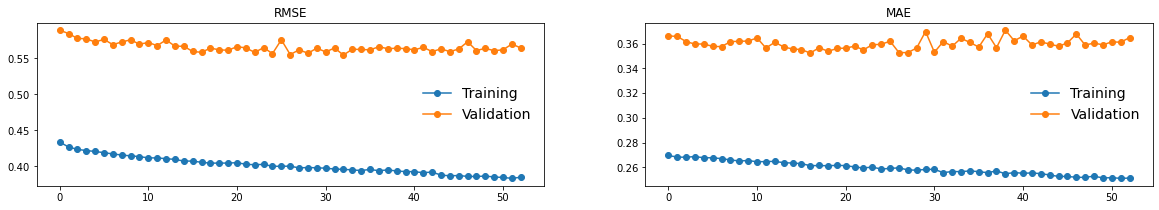

In [26]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized forecasting model

In [27]:
# Load the best model
#
model.load_weights('models/Seq2Seq_LSTM_diff.hdf5')

# Evaluation

## Get predictions

In [28]:
# Get predictions
#
pred = model.predict( testX )

## Inverse "Lag-d Diff" transformation

In [29]:
for i in range( Horizon ):
    testY[:, i] = test_CurrentValue - testY[:, i]
    pred[:, i]  = test_CurrentValue - pred[:, i]

## Apply inverse scaling/transformation

In [30]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

## Visualization of predictions

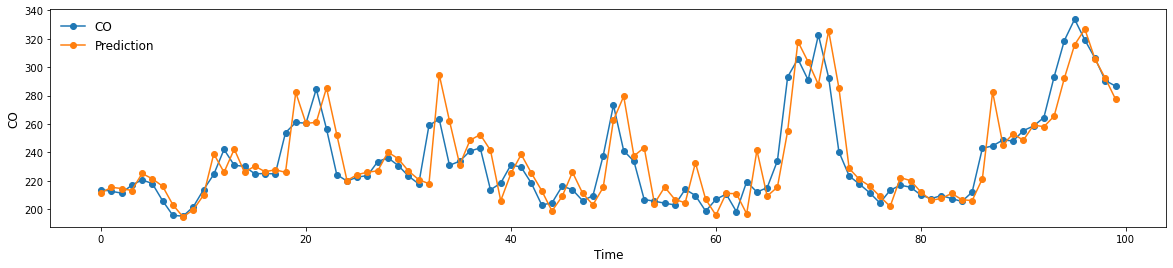

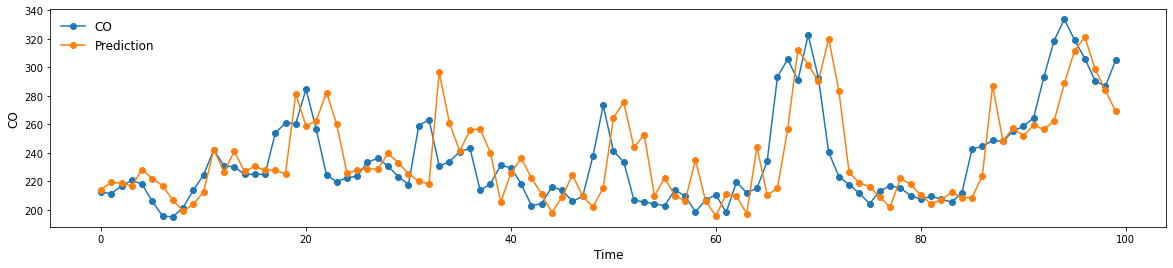

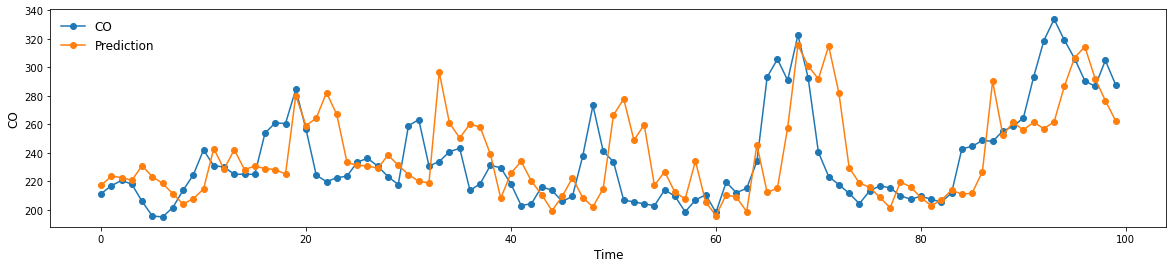

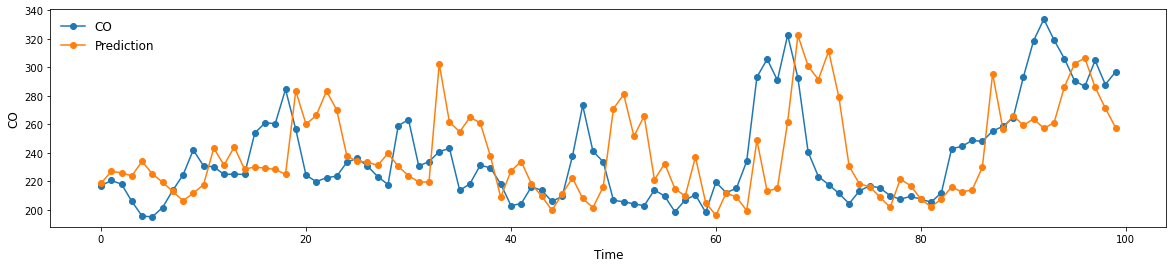

In [31]:
Results = dict()

for i in range( Horizon ):
    Prices = pd.DataFrame( [] )

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
    

        
    # Store results
    #
    Results[ 'Horizon {}'.format(i+1) ] = Prices

    
    
    
    # Plot results
    #
    plt.figure( figsize = (20, 4) );
    #
    Prices[ targetSeries ][:100].plot(color = 'tab:blue', marker = 'o')
    Prices[ 'Prediction' ][:100].plot(color = 'tab:orange', marker = 'o')
    
    #
    #
    plt.legend([targetSeries, 'Prediction'], fontsize = 12, frameon=False);
    plt.ylabel(targetSeries, size = 12 );
    plt.xlabel('Time', size = 12);
    plt.show()

## Regression evaluation

In [32]:
sResults = {'MAE': [], 'RMSE': [], 'MAPE': [], 'SMAPE': [], 'R2': []}

for i in range(Horizon):
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Results['Horizon {}'.format(i+1)] )
    
    sResults['MAE']   += [MAE]
    sResults['RMSE']  += [RMSE]
    sResults['MAPE']  += [MAPE]
    sResults['SMAPE'] += [SMAPE]
    sResults['R2']    += [R2]
    
    
#     print('Horizon -%i-' % (i+1))
#     print('--------------')
#     print('MAE   = %.3f' % MAE)
#     print('RMSE  = %.3f' % RMSE)
#     print('MAPE  = %.3f' % MAPE)
#     print('SMAPE = %.3f' % SMAPE)
#     print('R2    = %.3f' % R2)
#     print()
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

Horizon:  1 MAE  9.50 SMAPE:  4.61 R2: 0.94
Horizon:  2 MAE 17.09 SMAPE:  8.30 R2: 0.82
Horizon:  3 MAE 22.16 SMAPE: 10.81 R2: 0.71
Horizon:  4 MAE 26.41 SMAPE: 12.93 R2: 0.60


In [33]:
# CO - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.69 SMAPE:  4.69 R2: 0.94
# Horizon:  2 MAE 17.22 SMAPE:  8.34 R2: 0.81
# Horizon:  3 MAE 22.24 SMAPE: 10.82 R2: 0.70
# Horizon:  4 MAE 26.43 SMAPE: 12.90 R2: 0.59

# CO + NO2 - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.50 SMAPE:  4.61 R2: 0.94
# Horizon:  2 MAE 17.09 SMAPE:  8.30 R2: 0.82
# Horizon:  3 MAE 22.16 SMAPE: 10.81 R2: 0.71
# Horizon:  4 MAE 26.41 SMAPE: 12.93 R2: 0.60


# All data - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.63 SMAPE:  4.66 R2: 0.94
# Horizon:  2 MAE 17.01 SMAPE:  8.23 R2: 0.81
# Horizon:  3 MAE 21.96 SMAPE: 10.69 R2: 0.70
# Horizon:  4 MAE 26.04 SMAPE: 12.71 R2: 0.60


In [34]:
# print('[INFO] Feature: ', targetSeries)
# print('------------------------------------------------')
# Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

# for i in range( Horizon ):

#     Prices[targetSeries] = testY[:,i]
#     Prices['Prediction'] = pred[:,i]
    
            
#     from scipy import stats
#     from statsmodels.graphics.tsaplots import plot_acf
    
#     res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
#     fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

#     ax[0].hist( res, bins = 100 )    
#     plot_acf( res, ax=ax[1] )       

## Examples

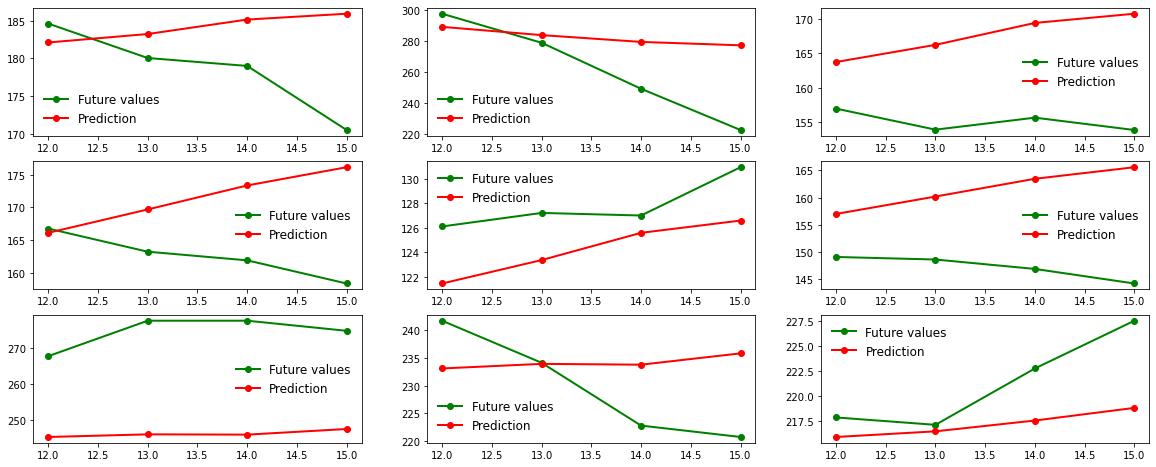

In [35]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
RandomInstances = [913, 205, 2254, 2007, 1829, 1144, 840, 713, 3457]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [36]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['Seq2Seq_LSTM_diff'] = pred.flatten()

Outputs.to_csv('Predictions/Seq2Seq_LSTM_diff.csv')